In [3]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [ ]:
%%capture
!gdown 1M5zP55fObbzme8C8nvJ7nT7Aa3NmYtbl

In [438]:
sayings = pd.read_csv("input/proverbs.csv.gz")
sayings.shape

(134493, 4)

In [439]:
sayings.sample(3)

,text,place,uri,collector
111271,Απ' τον Μάρτη καλοκαίρι κι από τον Αύγουστο χε...,"Κοζάνη, Βόϊο, Εράτυρα",http://hdl.handle.net/20.500.11853/278903,"Στρέμπας, Ιωάννης"
116573,Καίει του παπά την κατάρα,Κρήτη,http://hdl.handle.net/20.500.11853/210453,"Φραγκάκι, Ευαγγελία Κ."
36907,Του παππά η κοιλιά έν' κοφίνι όγοιος έν' κουτό...,"Κορινθία, Καρυά",http://hdl.handle.net/20.500.11853/259522,"Κακριδής, Ιωάννης Θ."


In [440]:
sayings[sayings.text.str.contains("=")].sample().text

90400    Όνου μόδου = Ogni modo = Εκών άκων
Name: text, dtype: object

In [441]:
# removing few definitions included
sayings = sayings[~sayings.text.str.contains("=")]
sayings.shape

(134106, 4)

In [442]:
print(f"{sayings.shape[0] - sayings.drop_duplicates().shape[0]} duplicates")

13875 duplicates


In [443]:
sayings["area"] = sayings.place.map(lambda x: x.split(",")[0])
sayings.sample(5)

,text,place,uri,collector,area
39824,Οι παράδες κάνουν τους ανθρώπους μασκαράδες,"Αρκαδία, Γορτυνία",http://hdl.handle.net/20.500.11853/252584,"Κανδηλώρος, Τάκης Χ.",Αρκαδία
100953,"Δε θα φέξει πλιά ο ήλιος τσαί για μας, Χ'στέ μου!",Σκύρος,http://hdl.handle.net/20.500.11853/195678,"Περδίκα, Νίκη Λ.",Σκύρος
30990,Έκαστος εκ των ιδίων έργων ή δοξασθήσεται ή αι...,Επτάνησος,http://hdl.handle.net/20.500.11853/207227,"Καββαδίας, Γεώργιος",Επτάνησος
73022,"Άλλο δεν τούνι λείπ' του Κασιδιάρ, μόν' η μαργ...","Ίμβρος, Χατζηγήριο",http://hdl.handle.net/20.500.11853/276688,"Μανασσείδης, Συμεών Α.",Ίμβρος
30582,Από τ' άλφα ώς το ωμέγα,Επτάνησος,http://hdl.handle.net/20.500.11853/146083,"Καββαδίας, Γεώργιος",Επτάνησος


In [446]:
# number of proverbs with no information about the location 
len(sayings[sayings.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

In [448]:
# geolocate to visualise the shared sayings
locations = sayings.area.unique()
len(locations)

134

In [58]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="sayings.gr")
geolocs = {}
for loc in locations:
    # Avoiding polysemy by including "Greece" in the query
    location = geolocator.geocode(loc+ ", Ελλάδα") 
    if location:
        geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
    else:
        print (loc)

Άδηλου τόπου
Φθιώτιδα
Αδριανούπολη
Δυτική Μάνη
Καππαδοκία
Δαρδανέλλια (Ελλήσποντος)
Αλβανία
Φωκίδα
Ημαθία
Βοιωτία
Αερόπολη
Τριφυλία
Μπλάτση
Ανατολική Κρήτη
Ανατολική Θράκη
Ανδρίτσαινα Ολυμπίου
Δυτική Κρήτη
Στερεά Ελλάδα
Ναυπακτία
Δωδεκάνησα
Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)


In [479]:
# fixing some by hand
location = geolocator.geocode("Cyprus")
geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Siteia")
geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Chania")
geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Nafpaktia")
geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Lepenou")
geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Cappadocia")
geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Imathia")
geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Boeotia")
geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Edirne")
geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phthiotis")
geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Andritsaina")
geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Dardanelles Strait")
geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Central Greece")
geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Areopoli")
geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Trifylia")
geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phocis")
geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("West Mani")
geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

In [480]:
sayings['lat'] = sayings.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
sayings['lon'] = sayings.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
sayings[sayings.lon.notna()].shape

(125222, 7)

# The anonymous collector

In [481]:
unnamed = sayings[sayings.collector=="anonymous"]
named = sayings[sayings.collector!="anonymous"]
print(f'{unnamed.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates

In [482]:
print(f'{sayings[sayings.collector!="anonymous"].duplicated().sum()} duplicate proverbs from named collectors')

29 duplicate proverbs from named collectors


In [483]:
# the areas of the duplicates by named collectors
sayings[(sayings.collector!="anonymous")&(sayings.duplicated())].area.unique()

array(['Κρήτη', 'Μικρά Ασία', 'Ήπειρος'], dtype=object)

In [484]:
# texts reported on multiple locations
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 3204 unique texts, 3204 exist in multiple areas


In [485]:
named.sample()

,text,place,uri,collector,area,lat,lon
88561,Τα πράσα αλοιφή δεν κάνουσι,Λακωνία,http://hdl.handle.net/20.500.11853/261530,"Νεστορίδης, Κ.",Λακωνία,36.760279,22.790464


In [486]:
# Exploring the areas of the duplicates, focusing on items by named collectors
grouping = named[named.lat.notna()&named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Κοζάνη, Βό...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Θράκη, Σηλ...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Κρήτη, Αχαΐα, Πάτρα, Αχαΐα, Καλάβρυτα, Μακεδο...",27


In [487]:
# finding the broader location
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Κοζάνη, Βό...",45,"{Κρήτη, Φιλιππούπολη, Πήλιο, Ιωάννινα, Μικρά Α...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Πέλλα, Γιαννιτσά, Αραβησσός, Σέρρες, Κοζάνη, ...",26,"{Κρήτη, Σέρρες, Πέλλα, Άνδρος, Φιλιππούπολη, Ι...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Θράκη, Σηλ...",28,"{Κρήτη, Μικρά Ασία, Εύβοια, Αδριανούπολη, Αχαΐ...",18


In [488]:
# some come from the same broad area
duplicates = duplicates[duplicates.area_num>1]

In [489]:
# summarising it all in a dataframe
duplicates['latlon'] = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                                        for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
Μ' αυτό το πλευρό να κοιμάσαι!,"{Ανατολική Θράκη, Αχαΐα, Πάτρα}",2,"{Ανατολική Θράκη, Αχαΐα}",2,"[(41.6759327, 26.5587225), (38.0692748, 21.872..."


In [490]:
duplicates.to_pickle("duplicates_geolocated.csv")

In [491]:
# visualising the dataframe (note that few are located in Italy, at Chiesa della Madona delle Neve)
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html")
m

In [524]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [525]:
# keeping single-placed proverbs
sayings_sp = sayings[~sayings.text.duplicated(keep=False)]
sayings_sp.sample(3)

,text,place,uri,collector,area,lat,lon
78767,Η μάνα μου και η μάνα του σ' έναν ήλιο άπλωναν...,"Μικρά Ασία, Βουρλά",http://hdl.handle.net/20.500.11853/195929,"Μηλιώρης, Νίκος Ε.",Μικρά Ασία,38.184637,23.512277
103262,Εγώ τό πλέρωσα τής εκκλησιάς τό κερί,"Μάνη, Αβία",http://hdl.handle.net/20.500.11853/262691,"Πουλάκης, Δ.",Μάνη,41.409747,26.402495
57401,Επεψέν τον να δη πο βρέσει,Κύπρος,http://hdl.handle.net/20.500.11853/194761,"Κυριαζής, Νίκος Γ.",Κύπρος,34.982302,33.145128


In [526]:
# keep aside single-placed proberbs from an unknown place
unlocated = "Άδηλου τόπου"
sayings_sp_unk = sayings_sp[sayings_sp.place==unlocated]
print(f'{sayings_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
sayings_sp_unk.sample(3)

2752 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
87234,Όχεντρα και μητρυιά εγκαρδιακά αδέρφια,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/282413,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
102782,Η μητρυία είναι οχιά,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/281412,"Ποταγός, Ν. Ν.",Άδηλου τόπου,NaN,NaN
102862,Μη δίκαζε πριν καλώς καταλάβης,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/165933,"Ποταγός, Ν. Ν.",Άδηλου τόπου,NaN,NaN


In [527]:
# working with the rest
sayings_sp = sayings_sp[sayings_sp.place!=unlocated]
print(f'{sayings_iop.shape[0]} proverbs from one place with known place name')

98064 proverbs from one place with known place name


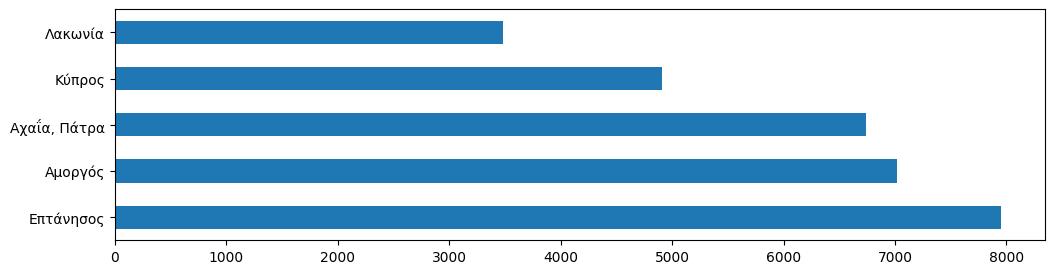

In [528]:
sayings_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

In [530]:
freq_places = sayings_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html'); m

In [497]:
group_level = "area"
placed = sayings_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


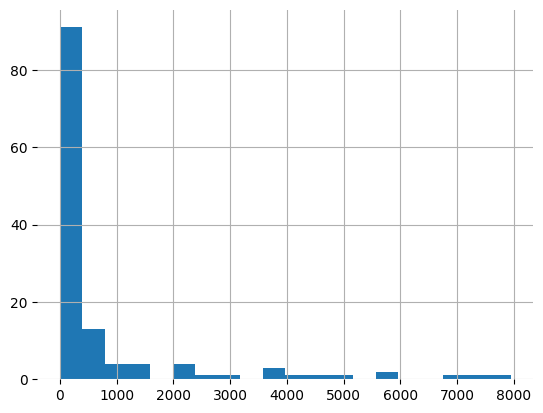

In [498]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

In [499]:
# places that are reported at least 1k times
common_places = placed_pd[placed_pd.length>1000].index
# filtering texts found on these places
common_sayings = sayings_iop[sayings_iop[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80837 proverbs from 23 places


In [500]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

In [501]:
# creating a balanced corpus
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

In [502]:
# one text per place
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
X = vect.fit_transform(long_texts)

In [503]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

In [505]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζα,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.007682,0.500711,0.0,0.009164,0.008323,0.0,0.0,0.000000,0.000000,0.018705
μ μ,0.0,0.006645,0.0,0.0,0.0,0.0,0.006786,0.000000,0.000000,0.0,...,0.000000,0.201882,0.0,0.000000,0.000000,0.0,0.0,0.024659,0.075474,0.000000
ζαί,0.0,0.005897,0.0,0.0,0.0,0.0,0.000000,0.006595,0.007324,0.0,...,0.000000,0.171986,0.0,0.000000,0.006908,0.0,0.0,0.000000,0.000000,0.005176


In [506]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}

In [507]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [353]:
geotfidf.to_csv("geotfidf.csv")

# Classifiying the place

## Machine learning

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

In [280]:
balanced_corpus.sample(3)

,text,place,uri,collector,area,lat,lon
107803,Η γλώσσα θρέφει κ' η γλώσσα καταστρέφει,"Θράκη, Σουφλί",http://hdl.handle.net/20.500.11853/182196,"Σεϊτανίδης, Δημήτριος",Θράκη,40.846424,25.875938
930,Τα λόγια πουτέ δε σουμό δεν έχιν,Λέσβος,http://hdl.handle.net/20.500.11853/214859,"Αναγνώστου, Σ.",Λέσβος,39.175842,25.998913
65599,"Γενάρη μήνα κλάδιβι, φιγγάρι μη γυερύης",Λέσβος,http://hdl.handle.net/20.500.11853/163885,"Λουκάτος, Δημήτριος Σ.",Λέσβος,39.175842,25.998913


Learning an MLP operating on character n-grams to classify places

                 precision    recall  f1-score   support

        Ήπειρος       0.07      0.08      0.07        37
        Αιτωλία       0.36      0.61      0.45        59
        Αμοργός       0.15      0.23      0.18        47
Ανατολική Θράκη       0.09      0.12      0.10        49
        Αρκαδία       0.15      0.11      0.13        53
          Αχαΐα       0.31      0.30      0.31        53
      Επτάνησος       0.34      0.35      0.35        48
         Εύβοια       0.12      0.12      0.12        42
      Θεσπρωτία       0.15      0.17      0.16        48
          Θράκη       0.13      0.10      0.11        51
       Ιωάννινα       0.23      0.18      0.21        60
       Κάρπαθος       0.46      0.36      0.40        53
     Κεφαλληνία       0.11      0.09      0.10        47
          Κρήτη       0.21      0.13      0.16        52
         Κύπρος       0.59      0.73      0.66        52
         Λέσβος       0.40      0.45      0.42        55
        Λακωνία       0.12    

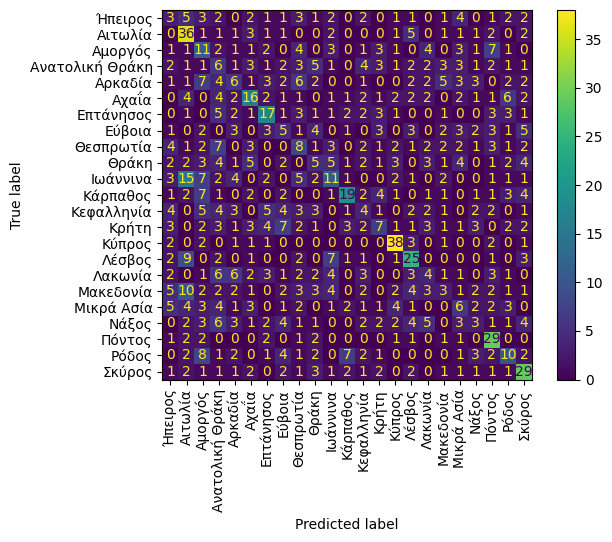

In [282]:
# text classification flat
train, test = train_test_split(balanced_corpus, test_size=0.1, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', RandomForestClassifier())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))
ConfusionMatrixDisplay.from_estimator(locator, test.text.values, test.area.values, xticks_rotation='vertical');

# Classifying non-located proverbs

In [283]:
unseen_predictions = locator.predict(sayings_iop_unl.text.values)
unseen_predictions_conf = locator.predict_proba(sayings_iop_unl.text.values)
unseen_predicted_pd = pd.DataFrame({"text": sayings_iop_unl.text, 
                                    "prediction": unseen_predictions, 
                                    "confidence": [max(x) for x in unseen_predictions_conf]})
unseen_predicted_pd.sort_values(by="confidence", ascending=False).head(10)

,text,prediction,confidence
117337,"Ανdάσ σου διούμ πκιάννε, τζ' ανdάθ θωρείς, μεν...",Κύπρος,0.78
18595,Δίνει τσ' κλέφτς ψουμί,Σκύρος,0.68
53824,Πήγε σαν το σκυλί στ' αμπέλι,Θεσπρωτία,0.66
99688,Το λόγον ατ δύο κ' εφτεάει,Πόντος,0.64
89938,"Αρμάστου αρμάστου, τσαί dεpοί τωρεί dυο μέραι ...",Σκύρος,0.64
42157,"Έδωκαν πρόσωπον τον Αλήν, κ' εσκώθεν κ' εσ' εσ...",Πόντος,0.63
82985,Δεν πας να βρης το λύκο;,Λακωνία,0.62
83423,Ένας νους κι' αυτός ρωμέικος!,Αχαΐα,0.62
96310,Τον έχουν από κλότσο κι από μπάτσο,Μικρά Ασία,0.60
86914,Όποιος πέρασ' από τη Σύνοδο έφαγε ψάρι σύνορο,Λακωνία,0.57


In [ ]:
unseen_predicted_pd.to_excel("sayings_located.xlsx", index=False)
unseen_predicted_pd[unseen_predicted_pd.confidence>0.9].shape

(0, 3)

In [ ]:
duplicated_predicted_pd = duplicates[duplicates.area_num>1]
duplicated_predicted_pd.insert(4, "prediction", locator.predict(duplicated_predicted_pd.index.values))
probs = locator.predict_proba(duplicated_predicted_pd.index.values)
duplicated_predicted_pd.insert(5, "confidence", probs.max(1))
duplicated_predicted_pd.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicated_predicted_pd.sort_values(by="confidence", ascending=False).head(20)

,place,place_num,area,area_num,prediction,confidence,latlon
text,,,,,,,
Αυτός είναι ανεμόμυλος,"[Αχαΐα, Πάτρα, Μικρά Ασία, Κυδωνία, Ανατολική ...",3,"{Ανατολική Θράκη, Αχαΐα, Μικρά Ασία}",3,Αχαΐα,0.84,"[(41.6759327, 26.5587225), (38.0692748, 21.872..."
Ξυέται εκεί που δεν τον τρώει,"[Κοζάνη, Βόϊο, Γαλατινή, Αχαΐα, Πάτρα]",2,"{Αχαΐα, Κοζάνη}",2,Μακεδονία,0.83,"[(38.0692748, 21.87273042232539), (40.3007259,..."
Του παπά το πετραχήλι ποταμός είναι και σύρνει,"[Αμοργός, Κρήτη, Λασίθι, Τζερμιάδο, Κάρπαθος, ...",4,"{Αμοργός, Κρήτη, Εύβοια, Κάρπαθος}",4,Νάξος,0.82,"[(36.85252415, 25.898486967715655), (35.308495..."
Του χωριάτη το σκοινί μονό δέ φτάνει και διπλό περισσεύει,"[Κρήτη, Ινναχώριο, Τοπόλια, Κρήτη, Σητεία, Σκο...",3,"{Κρήτη, Ικαρία}",2,Κρήτη,0.81,"[(35.308495199999996, 24.46334231842296), (37...."
Ανάθρεψε τον ποντικό να φάη το σακκί σου,"[Νάξος, Απείρανθος, Ηλεία, Νεοχώρι]",2,"{Ηλεία, Νάξος}",2,Κρήτη,0.81,"[(37.993211, 23.652030018749997), (37.06001045..."
Το παιδάκι σου και το σκυλάκι σου όπως το μάθης,"[Λακωνία, Σπάρτη, Αθήνα]",2,"{Λακωνία, Αθήνα}",2,Αρκαδία,0.79,"[(36.76027945, 22.79046431389755), (37.9839412..."
Το σκύλο κάμε σύντεκνο και το ραβδί σου βάστα,"[Χίος, Καρδάμυλα, Λακωνία]",2,"{Χίος, Λακωνία}",2,Κρήτη,0.76,"[(38.37581315, 26.064655246170453), (36.760279..."
Το γουδί το γουδοχέρ',"[Θράκη, Σαράντα Εκκλησίες, Ήπειρος, Κόνιτσα]",2,"{Ήπειρος, Θράκη}",2,Θράκη,0.75,"[(37.9982534, 23.7378671), (40.8464241, 25.875..."
Αυτός είναι μη μου άπτου,"[Αμοργός, Ιωάννινα, Νεγάδες]",2,"{Ιωάννινα, Αμοργός}",2,Αχαΐα,0.73,"[(39.6639818, 20.8522784), (36.85252415, 25.89..."


# Authorship analysis


In [346]:
#!git clone https://github.com/ipavlopoulos/lm
# training one model per area, by sampling proverbs of that area
# WARNING: not robust
from lm.markov.models import LM
models = {}
for area in train.area.unique():
    texts = train[train.area==area].sample(300).text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))
    
def ling_dist(proverb, models=models):
    entropy = {loc:[models[loc].cross_entropy(proverb)] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Επτάνησος,Ιωάννινα,Θεσπρωτία,Εύβοια,Ρόδος,Κρήτη,Λακωνία,Ανατολική Θράκη,Κεφαλληνία,Μικρά Ασία,...,Νάξος,Κύπρος,Σκύρος,Αχαΐα,Θράκη,Αιτωλία,Αμοργός,Λέσβος,Μακεδονία,Πόντος
0,2.880414,3.396508,3.633337,3.83149,4.172114,4.177863,4.326928,4.406372,4.433669,4.703101,...,4.955898,5.016818,5.163095,5.165631,5.305463,5.434768,5.657341,5.676162,5.844187,6.00563


# Regression on the coordinates
By training to predict lat and lon we can see how specific words push the prediction toward west/east and north/south.

In [106]:
# regression (lat/lon) - at the word level for efficiency
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

In [117]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 0.999
R2 (dev): -8.188


In [108]:
print(f"MAE lat/lon: {mean_absolute_error(test.lat.values, txt_preds[:, 0]):.2f} / {mean_absolute_error(test.lon.values, txt_preds[:, 1]):.2f}")

MAE lat/lon: 3.14 / 5.16


In [110]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

In [111]:
# features pushing to the north (higher lat)
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
4917,η τα,54.922218,30.067870
94160,ρός θ,49.253538,26.485425
106550,υ επή,47.458841,-53.404535
64712,λαστα,45.781660,18.749909
13052,' ο μ,45.455503,3.157250


In [112]:
# features pushing to the south (lower lat)
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
33230,ανου,-61.492329,39.833199
64265,λα γέ,-55.617312,79.816255
12021,όσον,-53.031113,20.946564
103153,τη πό,-51.904867,-2.335648
10214,τ' α,-50.833145,15.832440


Some words (fatto, gui) reveal noise in the data, for example coming from explanatory comments. It can be cleaned by removing any comments with "=".

In [113]:
# features pushing to the east (higher lon)
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
119865,ύφη θ,-10.909252,94.215935
33617,απέσ',2.330100,84.160920
66254,λο,0.575889,83.106898
64265,λα γέ,-55.617312,79.816255
103813,το,-9.021572,74.645164


In [114]:
# features pushing to the west (lower lon)
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
103812,το,-0.752532,-169.268858
59639,κα,-0.274963,-148.054893
82867,ου,14.735236,-145.876393
101638,τα,3.838032,-136.805081
73932,να,16.299754,-131.291371


# Next steps
* Fine tune GreekBERT on lat/lon regression
  * Done: didn't do better than extra trees
* Evaluate regression with classification metrics (assign to closest area)
  * Done: didn't do better than classification algorithms
* Put words on a map based on their (linear regression) importance
* Focus on one saying, performing agglomerative clustering to reveal its progress
